In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torchvision import transforms, models
from sklearn.metrics import average_precision_score
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

from models import Veggie_Classifier

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
train_dir='./Vegetable Images/train'
val_dir='./Vegetable Images/validation'
test_dir='./Vegetable Images/test'

In [3]:
VEGETABLE_CLASSES = ['Bean', 'Bitter Gourd', 'Bottle Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']
NUM_CLASSES = len(VEGETABLE_CLASSES)

In [4]:
def train_classifier(train_loader, classifier, criterion, optimizer):
    classifier.train()
    loss_ = 0.0
    losses = []
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = classifier(images)
        labels = F.one_hot(labels, NUM_CLASSES)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss)
    return torch.stack(losses).mean().item()

In [5]:
def test_classifier(test_loader, classifier, criterion, print_ind_classes=True, print_total=True):
    classifier.eval()
    losses = []
    with torch.no_grad():
        y_true = np.zeros((0,NUM_CLASSES))
        y_score = np.zeros((0,NUM_CLASSES))
        for i, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            logits = classifier(images)
            labels = F.one_hot(labels, NUM_CLASSES)
            y_true = np.concatenate((y_true, labels.cpu().numpy()), axis=0)
            y_score = np.concatenate((y_score, logits.cpu().numpy()), axis=0)
            loss = criterion(logits, labels)
            losses.append(loss.item())
        aps = []
        # ignore first class which is background
        for i in range(1, y_true.shape[1]):
            ap = average_precision_score(y_true[:, i], y_score[:, i])
            if print_ind_classes:
                print('-------  Class: {:<12}     AP: {:>8.4f}  -------'.format(VEGETABLE_CLASSES[i], ap))
            aps.append(ap)
        
        mAP = np.mean(aps)
        test_loss = np.mean(losses)
        if print_total:
            print('mAP: {0:.4f}'.format(mAP))
            print('Avg loss: {}'.format(test_loss))
        
    return mAP, test_loss, aps

In [6]:
def plot_losses(train, val, test_frequency, num_epochs):
    plt.plot(train, label="train")
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0)]
    plt.plot(indices, val, label="val")
    plt.title("Loss Plot")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()
    
def plot_mAP(train, val, test_frequency, num_epochs):
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0)]
    plt.plot(indices, train, label="train")
    plt.plot(indices, val, label="val")
    plt.title("mAP Plot")
    plt.ylabel("mAP")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

In [7]:
def train(classifier, num_epochs, train_loader, val_loader, criterion, optimizer, scheduler, test_frequency=5):
    train_losses = []
    train_mAPs = []
    val_losses = []
    val_mAPs = []

    for epoch in range(1,num_epochs+1):
        print("Starting epoch number " + str(epoch))
        train_loss = train_classifier(train_loader, classifier, criterion, optimizer)
        train_losses.append(train_loss)
        print("Loss for Training on Epoch " +str(epoch) + " is "+ str(train_loss))
        if(epoch%test_frequency==0 or epoch==1):
            mAP_train, _, _ = test_classifier(train_loader, classifier, criterion, False, False)
            train_mAPs.append(mAP_train)
            mAP_val, val_loss, _ = test_classifier(val_loader, classifier, criterion)
            print('Evaluating classifier')
            print("Mean Precision Score for Testing on Epoch " +str(epoch) + " is "+ str(mAP_val))
            val_losses.append(val_loss)
            val_mAPs.append(mAP_val)
            
            scheduler.step()
    
    return classifier, train_losses, val_losses, train_mAPs, val_mAPs

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std= [0.229, 0.224, 0.225])

train_transform = transforms.Compose([
                                     transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.RandomRotation(15),
                                     transforms.ColorJitter(brightness=0.2,contrast=0.1,hue=0.1,saturation=0.1),
                                     transforms.RandomAffine(degrees=15, translate=(0.1,0.1), scale=(1, 2), shear=15),
                                     transforms.GaussianBlur(kernel_size=(5,9)),
                                     transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     normalize
                                     ])

test_transform = transforms.Compose([                             
                                     transforms.Resize((224,224)),
                                     transforms.ToTensor(), 
                                     normalize
                                     ])

In [9]:
num_epochs = 10
test_frequency = 5
batch_size = 64

train_dataset=torchvision.datasets.ImageFolder(root=train_dir,transform=train_transform)
val_dataset=torchvision.datasets.ImageFolder(root=val_dir,transform=test_transform)
test_dataset=torchvision.datasets.ImageFolder(root=test_dir,transform=test_transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size, 
                                               shuffle=True,
                                               num_workers=1)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                               batch_size=batch_size, 
                                               shuffle=True,
                                               num_workers=1)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                               batch_size=batch_size, 
                                               shuffle=False,
                                               num_workers=1)

In [10]:
# TODO: Run your own classifier here
classifier = Veggie_Classifier().to(device)

criterion = nn.MultiLabelSoftMarginLoss()
# optimizer = torch.optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.9)

classifier, train_losses, val_losses, train_mAPs, val_mAPs = train(classifier, num_epochs, train_loader, val_loader, criterion, optimizer, scheduler, test_frequency)

Starting epoch number 1
Loss for Training on Epoch 1 is 0.1988183856010437
-------  Class: Bitter Gourd     AP:   0.6124  -------
-------  Class: Bottle Gourd     AP:   0.6606  -------
-------  Class: Brinjal          AP:   0.3883  -------
-------  Class: Broccoli         AP:   0.7896  -------
-------  Class: Cabbage          AP:   0.5754  -------
-------  Class: Capsicum         AP:   0.8095  -------
-------  Class: Carrot           AP:   0.9724  -------
-------  Class: Cauliflower      AP:   0.5527  -------
-------  Class: Cucumber         AP:   0.5525  -------
-------  Class: Papaya           AP:   0.7111  -------
-------  Class: Potato           AP:   0.8637  -------
-------  Class: Pumpkin          AP:   0.7600  -------
-------  Class: Radish           AP:   0.8321  -------
-------  Class: Tomato           AP:   0.6948  -------
mAP: 0.6982
Avg loss: 0.14130836249666012
Evaluating classifier
Mean Precision Score for Testing on Epoch 1 is 0.6982284903307631
Starting epoch number 2
L

In [11]:
torch.save(classifier.state_dict(), './saved_models/veggie_classifier.pth')

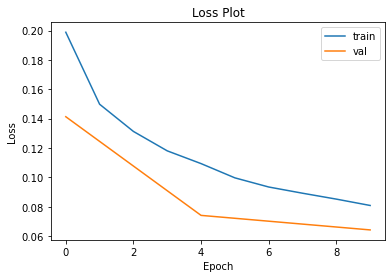

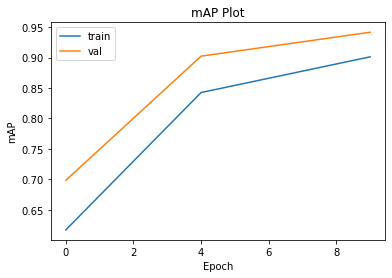

In [12]:
plot_losses(train_losses, val_losses, test_frequency, num_epochs)
plot_mAP(train_mAPs, val_mAPs, test_frequency, num_epochs)

In [13]:
mAP_test, test_loss, test_aps = test_classifier(test_loader, classifier, criterion)
print(mAP_test)

-------  Class: Bitter Gourd     AP:   0.9496  -------
-------  Class: Bottle Gourd     AP:   0.9571  -------
-------  Class: Brinjal          AP:   0.8307  -------
-------  Class: Broccoli         AP:   0.9315  -------
-------  Class: Cabbage          AP:   0.9183  -------
-------  Class: Capsicum         AP:   0.9819  -------
-------  Class: Carrot           AP:   0.9995  -------
-------  Class: Cauliflower      AP:   0.9211  -------
-------  Class: Cucumber         AP:   0.8751  -------
-------  Class: Papaya           AP:   0.9244  -------
-------  Class: Potato           AP:   0.9818  -------
-------  Class: Pumpkin          AP:   0.9843  -------
-------  Class: Radish           AP:   0.9783  -------
-------  Class: Tomato           AP:   0.9150  -------
mAP: 0.9392
Avg loss: 0.06401040772610206
0.9391924250724827
